# 🛰️ Mount Kenya Land Cover Classification Using Landsat Natural Color Imagery

This notebook demonstrates a full land cover classification workflow using **natural color Landsat imagery** and **training polygons** manually created in GIS software or Google Earth Engine and exported as Shapefiles.

**Required Inputs (stored locally):**
- `mount_kenya_training_polygons.shp` (shapefile of labeled training areas)
- `mount_kenya_truecolor_rgb.tif` (natural color image from Landsat)

These files should be stored in a local project directory, e.g.:  
`C:/Users/Vincent/OneDrive - Michigan State University/Desktop/DrMoore_Classification`

The workflow includes:
1. Loading polygon-based training data and a Landsat RGB image
2. Extracting band statistics (Red, Green, Blue) from image under each polygon
3. Training a **Random Forest classifier**
4. Applying the classifier to the entire image
5. Saving and visualizing the results with a labeled legend

This code is structured for deployment using **Jupyter Notebook in Anaconda Navigator**, with **no dependency on Google services**.


## 🔹 1. Install and Import Required Libraries

In [1]:
pip install geopandas rasterio rasterstats scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import required libraries
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
from rasterstats import zonal_stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os


## 🔹 Ignore Warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 🔹 Step 1: Load Training Polygons and Natural Color Raster

We load:
- A `.shp` file containing labeled polygons representing known land cover types.
- A 3-band Landsat image (`.tif`) representing Red, Green, and Blue channels.

Ensure the files are stored locally and accessible to your working directory.


In [4]:
# Define your local file paths
data_dir = "C:/Users/Vincent/OneDrive - Michigan State University/Desktop/DrMoore_Classification/Data"

shapefile_path = os.path.join(data_dir, "mount_kenya_training_polygons.shp")
raster_path = os.path.join(data_dir, "mount_kenya_truecolor_rgb.tif")

# Load training polygons
gdf = gpd.read_file(shapefile_path)

# Open raster file for reference
src = rasterio.open(raster_path)
print("Raster CRS:", src.crs)
print("Number of bands:", src.count)


Raster CRS: EPSG:4326
Number of bands: 3


## 🔹 Step 2: Visualize the Natural Color Image and Training Polygons


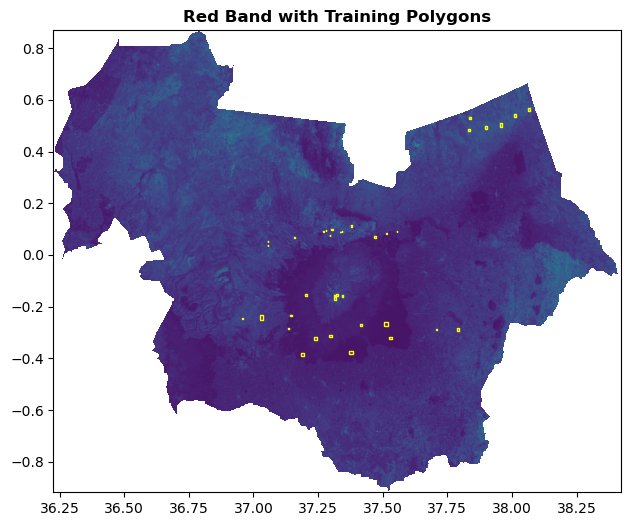

In [5]:
from rasterio.plot import show
fig, ax = plt.subplots(figsize=(10, 6))
show((src, 1), ax=ax, title="Red Band with Training Polygons")
gdf.plot(ax=ax, facecolor='none', edgecolor='yellow')
plt.show()


## 🔹 Step 3: Extract Band Mean Values from Training Polygons

We use `rasterstats.zonal_stats` to compute the **mean value of each band (Red, Green, Blue)** under each labeled polygon. This gives us structured input data for supervised learning.


In [6]:
# Red band stats
stats = zonal_stats(gdf, raster_path, stats=["mean"], band=1, prefix='R_')
features_df = pd.DataFrame(stats)

# Green and Blue
for band, prefix in [(2, 'G_'), (3, 'B_')]:
    stats = zonal_stats(gdf, raster_path, stats=["mean"], band=band, prefix=prefix)
    features_df = features_df.join(pd.DataFrame(stats))

# Append landcover label
features_df["landcover"] = gdf["landcover"]
features_df = features_df.dropna()

features_df.head()


,R_mean,G_mean,B_mean,landcover
0,0.790418,0.835508,0.788944,0
1,0.789879,0.836968,0.801982,0
2,0.803496,0.855254,0.807869,0
3,0.784292,0.835831,0.795331,0
4,0.859805,0.916952,0.835143,1


## 🔹 Step 4: Train a Random Forest Classifier

We split the extracted features into a training and testing set. A **Random Forest** classifier is trained to learn the land cover classes from the RGB band values.


In [7]:
X = features_df[["R_mean", "G_mean", "B_mean"]].values
y = features_df["landcover"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

print("Training Accuracy:", clf.score(X_train, y_train))
print("Test Accuracy:", clf.score(X_test, y_test))


Training Accuracy: 1.0
Test Accuracy: 1.0


## 🔹 Step 5: Classify the Entire Image

We apply the trained model to classify each pixel in the image based on its RGB values.


In [8]:
with rasterio.open(raster_path) as src:
    img = src.read()
    profile = src.profile

rows, cols = img.shape[1], img.shape[2]
R, G, B = img[0].flatten(), img[1].flatten(), img[2].flatten()
pixel_data = np.stack((R, G, B), axis=-1)

mask = np.all(pixel_data > 0, axis=1)
pixel_data_clean = pixel_data[mask]

predictions = np.full(pixel_data.shape[0], -1)
predictions[mask] = clf.predict(pixel_data_clean)
classified = predictions.reshape((rows, cols))


## 🔹 Step 6: Save Classified Raster

We write the classification result to a new `.tif` raster.


In [9]:
output_path = "output/classified_mount_kenya.tif"
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')

os.makedirs("output", exist_ok=True)

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(classified.astype(rasterio.uint8), 1)

print("Classified raster saved to:", output_path)


Classified raster saved to: output/classified_mount_kenya.tif


## 🔹 Step 7: Visualize the Classified Map with Legend


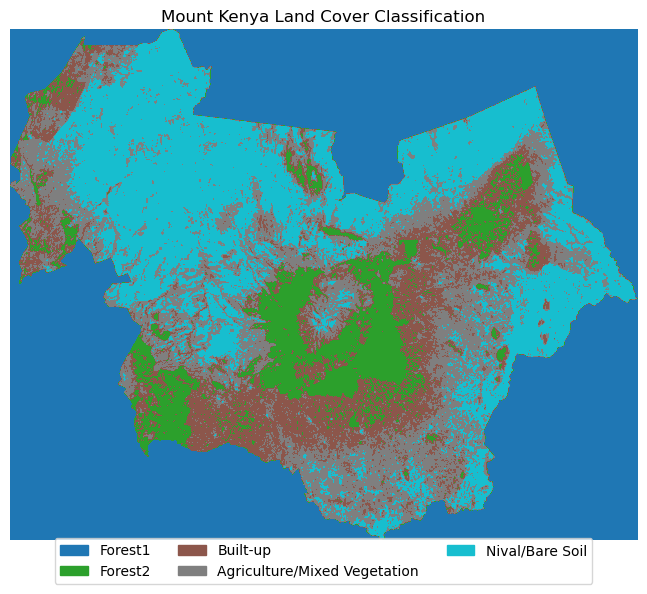

In [10]:
import matplotlib.patches as mpatches

class_names = {
    0: "Forest1",
    1: "Forest2",
    2: "Built-up",
    3: "Agriculture/Mixed Vegetation",
    4: "Nival/Bare Soil"
}

plt.figure(figsize=(10, 6))
cmap = plt.get_cmap('tab10', len(class_names))
im = plt.imshow(classified, cmap=cmap)
plt.title("Mount Kenya Land Cover Classification")
plt.axis('off')

# Legend
handles = [mpatches.Patch(color=cmap(i), label=label) for i, label in class_names.items()]
plt.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout()
plt.show()
